# Aggregating manual annotations and correlations

We read the evaluation results from excel files that have the following columns:

Turn	
Speaker	
Cue	
Response	
Context

System ratings
* MLM response	
* System llh	
* MLM llh	
* USR DLcontext	
* USR DLfact	

Human ratings:
* Overall Human Rating	
* Interesting	
* Engaging	
* Specific	
* Relevant	
* Correct	
* Semantically Appropriate	
* Understandable	
* Fluent

In [1]:
# Needed to calculate the mean square error for regression scores
#! pip install sklearn

In [2]:
### Needed to read Ecel files: xlsx
# ! pip install openpyxl

In [31]:
from pathlib import Path
import glob
import pandas as pd
import json
import math
import numpy as np
import matplotlib.pyplot as plt

group = "g1-piek"
#group = "g2-jaap"
#group = "g3-lea"
#group = "g4-tae"
annotation_path = "/Users/piek/Desktop/t-MA-Combots-2021/evaluation/leolani2-evaluations/"+group+"/scenario1"
#annotation_path = "."
basepath = Path(annotation_path)

In [46]:
def get_score_triples_from_turn(json_row:str, speaker_scores:{}, auto_score:str, hum_score:str):
    speaker = json_row['Speaker']
    turn = json_row['Turn']
    auto = json_row[auto_score]
    hum = json_row[hum_score]
    triple = (turn, auto, hum)
    if not speaker_scores.get(speaker):
        speaker_scores[speaker]=[]
    speaker_scores[speaker].append(triple)
    
def evaluate_regression_scores(basepath:Path, speaker_scores:{},auto_score:str, hum_score:str):
    turn_index =[]
    speaker_scores:{}
    for path in basepath.glob('*.csv'):
        df = pd.read_csv(path)
        print(path)
        js = df.to_json(orient = 'records')
        for turn in json.loads(js):
            get_score_triples_from_turn(turn, speaker_scores, auto_score,hum_score)

def get_scores_for_turns(json_row:str, turn_scores:{}, score_name:str):
    turn = json_row['Turn']
    score = json_row[score_name]
    if score:
        if not turn_scores.get(turn):
            turn_scores[turn]=[]
        turn_scores[turn].append(score)

def get_score_for_turns(json_row:str, turn_scores:{}, score_name:str):
    turn = json_row['Turn']
    score = json_row[score_name]
    if score:
        turn_scores[turn]= score

def get_normalized_human_scores(basepath:Path, score_name:str):
    all_turn_scores = {}
    normalized_scores = {}
    averaged_score = []
    for path in basepath.glob('*.csv'):
        df = pd.read_csv(path)
        if 'Turn' in df:
            print(path)
            js = df.to_json(orient = 'records')
            turn_scores={}
            for turn in json.loads(js):
                get_scores_for_turns(turn, turn_scores, score_name)
            for turn_id in turn_scores:
                if not all_turn_scores.get(turn_id):
                    all_turn_scores[turn_id]=[]
                all_turn_scores[turn_id].extend(turn_scores[turn_id])

    for turn_id in all_turn_scores:
        scores = all_turn_scores[turn_id]
        average = sum(scores)/len(scores)
        averaged_score.append(average)
        normalized_score = (average-1)/4
        normalized_scores[turn_id]=normalized_score
    averaged_score = sum(averaged_score)/len(averaged_score)
    #print(normalized_scores)
    #print(averaged_score)
    return normalized_scores, averaged_score

## Averaging the human annotations 

In [47]:
score_name = "Overall Human Rating"
normalized_scores_overall, average_overall = get_normalized_human_scores(basepath, score_name)

score_name = "Interesting"
normalized_scores_interesting, average_interesting = get_normalized_human_scores(basepath, score_name)

score_name = "Engaging"
normalized_scores_engaging, average_engaging = get_normalized_human_scores(basepath, score_name)

score_name = "Specific"
normalized_scores_specific, average_specific = get_normalized_human_scores(basepath, score_name)

score_name = "Relevant"
normalized_scores_relevant, average_relevant = get_normalized_human_scores(basepath, score_name)

score_name = "Correct"
normalized_scores_correct, average_correct = get_normalized_human_scores(basepath, score_name)

score_name = "Semantically Appropriate"
normalized_scores_semantic, average_semantic = get_normalized_human_scores(basepath, score_name)

score_name = "Understandable"
normalized_scores_understandable, average_understand = get_normalized_human_scores(basepath, score_name)

score_name = "Fluent"
normalized_scores_fluent, average_fluent = get_normalized_human_scores(basepath, score_name)

/Users/piek/Desktop/t-MA-Combots-2021/evaluation/leolani2-evaluations/g1-piek/scenario1/2021-12-07-16-26-14_turns83_fina.csv
/Users/piek/Desktop/t-MA-Combots-2021/evaluation/leolani2-evaluations/g1-piek/scenario1/2021-12-07-16-26-14_truns83_imme.csv
/Users/piek/Desktop/t-MA-Combots-2021/evaluation/leolani2-evaluations/g1-piek/scenario1/2021-12-07-16_26_14_turns83_thomas.csv
3.1550387596899223
/Users/piek/Desktop/t-MA-Combots-2021/evaluation/leolani2-evaluations/g1-piek/scenario1/2021-12-07-16-26-14_turns83_fina.csv
/Users/piek/Desktop/t-MA-Combots-2021/evaluation/leolani2-evaluations/g1-piek/scenario1/2021-12-07-16-26-14_truns83_imme.csv
/Users/piek/Desktop/t-MA-Combots-2021/evaluation/leolani2-evaluations/g1-piek/scenario1/2021-12-07-16_26_14_turns83_thomas.csv
2.6511627906976742
/Users/piek/Desktop/t-MA-Combots-2021/evaluation/leolani2-evaluations/g1-piek/scenario1/2021-12-07-16-26-14_turns83_fina.csv
/Users/piek/Desktop/t-MA-Combots-2021/evaluation/leolani2-evaluations/g1-piek/scena

In [39]:
print(average_overall)
print(average_interesting)
print(average_engaging)
print(average_specific)
print(average_relevant)
print(average_correct)
print(average_semantic)
print(average_understand)
print(average_fluent)

3.1550387596899223
2.6511627906976742
2.790697674418605
2.9379844961240313
3.248062015503875
3.1472868217054257
3.0620155038759687
3.751937984496124
3.6356589147286815


### Visualising the human ratings over turns

In [6]:
def extend__with_bar(width, normalized_scores:{}, score_name:str, plt, colors:[], used_colors):
    turns = list(normalized_scores.keys())
    ###We take all turns from the turn_index to create the x-axis
    x = np.arange(len(turns))
    y = []
    for key in normalized_scores:
        y.append(normalized_scores[key])
    c1 = choice(colors)   
    while c1 in used_colors:
        c1 = choice(colors)
    
    used_colors.append(c1)
    plt.barh(x+width, y,  color=c1, edgecolor="black", label=score_name, height=0.1)
    #plt.bar(x+width, y,  color=c1, width=barWidth, edgecolor="black", label=score_name)

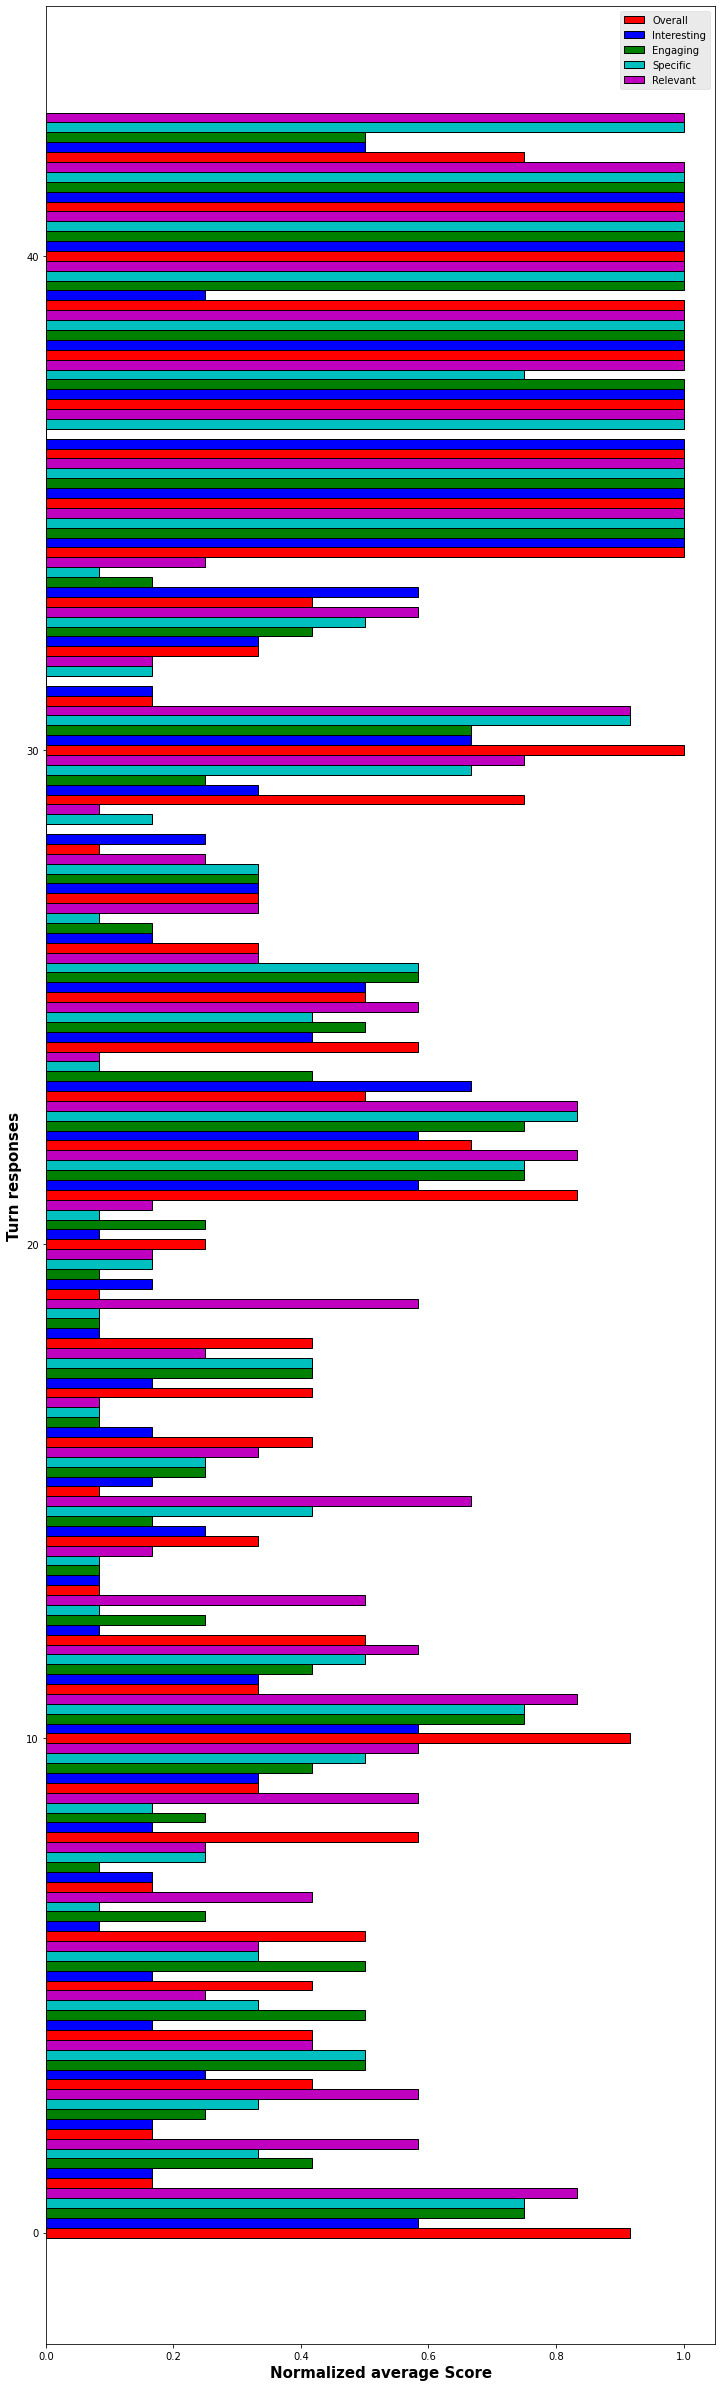

In [7]:
from random import getrandbits, choice
barWidth = 0.2
fig = plt.subplots(figsize =(12, len(normalized_scores_overall)))
colors=["b","r","g","y","c", "m", "b", "w", "grey", "orange"]
used_colors = []

score_name = "Overall"
extend__with_bar(0, normalized_scores_overall, score_name, plt, ["r"], used_colors)

score_name = "Interesting"
extend__with_bar(0.2,normalized_scores_interesting, score_name, plt, colors, used_colors)
score_name = "Engaging"
extend__with_bar(0.4,normalized_scores_engaging, score_name, plt, colors, used_colors)
score_name = "Specific"
extend__with_bar(0.6,normalized_scores_specific, score_name, plt, colors, used_colors)
score_name = "Relevant"
extend__with_bar(0.8,normalized_scores_relevant, score_name, plt, colors, used_colors)

plt.style.use('ggplot')
plt.xlabel('Normalized average Score', fontweight ='bold', fontsize = 15)
plt.ylabel('Turn responses', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

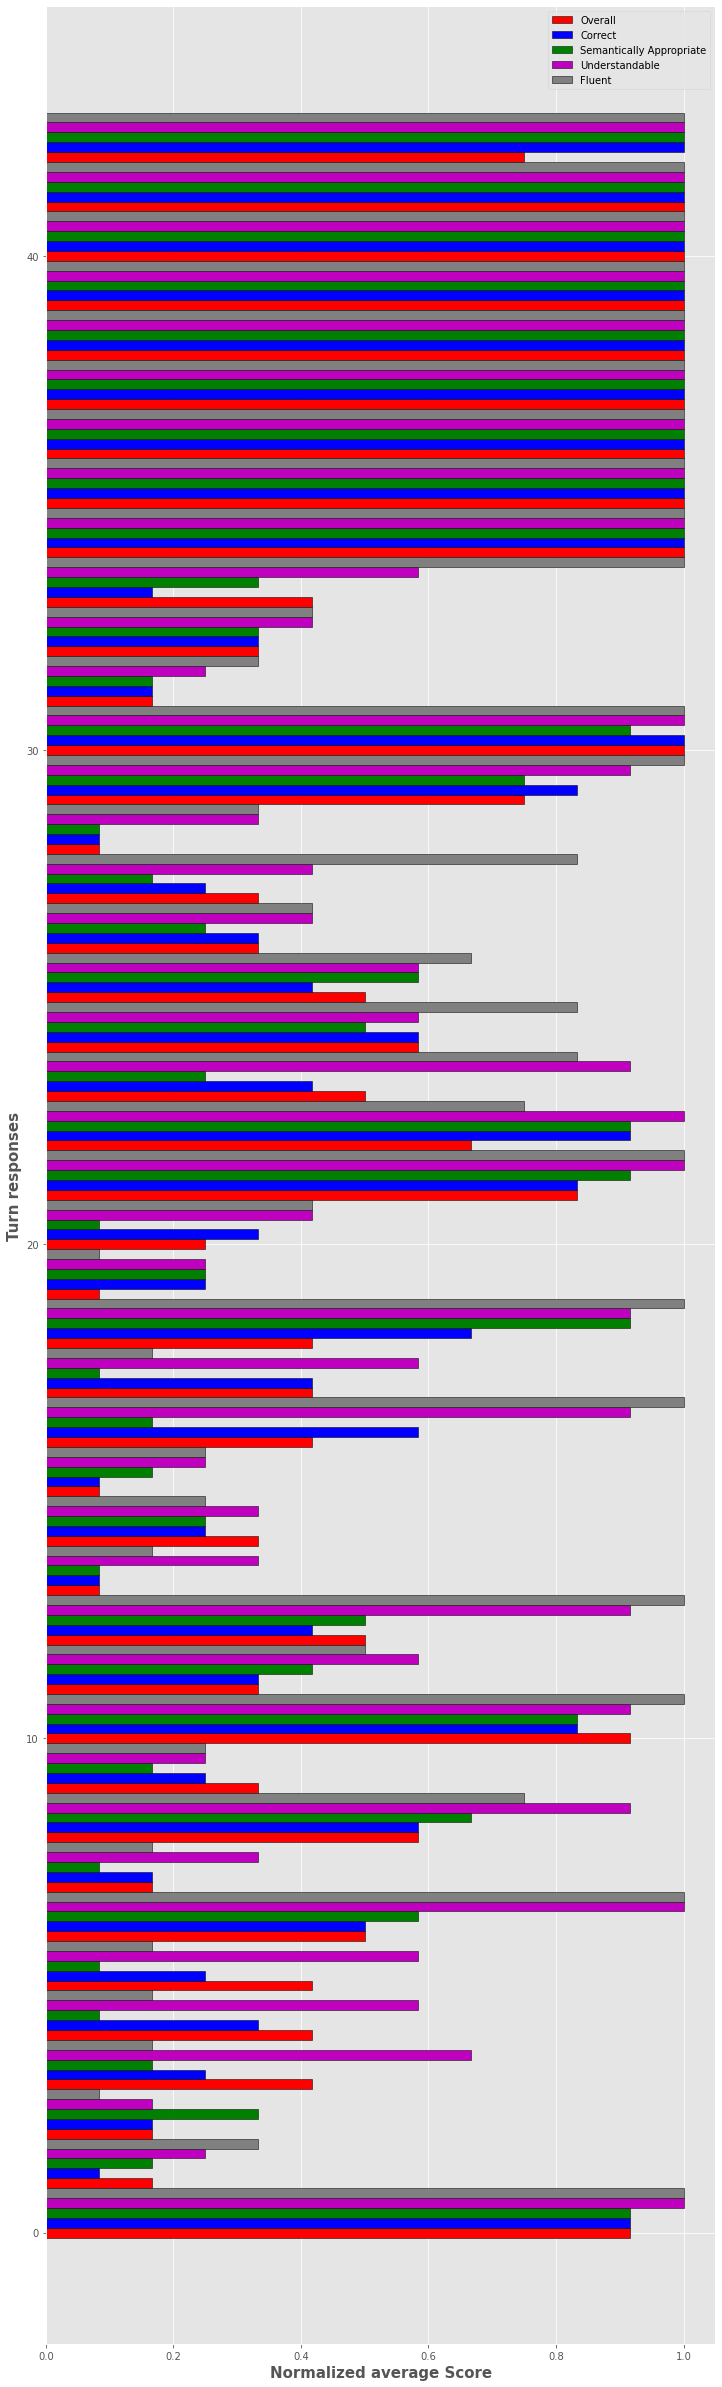

In [8]:
from random import getrandbits, choice
barWidth = 0.2
fig = plt.subplots(figsize =(12, len(normalized_scores_overall)))
colors=["b","r","g","y","c", "m", "b", "w", "grey", "orange"]
used_colors = []

score_name = "Overall"
extend__with_bar(0, normalized_scores_overall, score_name, plt, ["r"], used_colors)

score_name = "Correct"
extend__with_bar(0.2,normalized_scores_correct, score_name, plt, colors, used_colors)
score_name = "Semantically Appropriate"
extend__with_bar(0.4,normalized_scores_semantic, score_name, plt, colors, used_colors)
score_name = "Understandable"
extend__with_bar(0.6,normalized_scores_understandable, score_name, plt, colors, used_colors)
score_name = "Fluent"
extend__with_bar(0.8,normalized_scores_fluent, score_name, plt, colors, used_colors)

plt.style.use('ggplot')
plt.ylabel('Turn responses', fontweight ='bold', fontsize = 15)
plt.xlabel('Normalized average Score', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

### Correlating the human annotations with overall rating

In [9]:
#https://medium.com/analytics-vidhya/mae-mse-rmse-coefficient-of-determination-adjusted-r-squared-which-metric-is-better-cd0326a5697e
#https://medium.com/human-in-a-machine-world/mae-and-rmse-which-metric-is-better-e60ac3bde13d
from sklearn.metrics import mean_squared_error, mean_absolute_error

def get_mean_error_area(scores_x, scores_y):
    x = []
    for key in scores_x:
        x.append(scores_x[key])
    y = []
    for key in scores_y:
        y.append(scores_y[key])

    dif=(len(x)-len(y))
    if dif>0:
        for i in range(dif):
            y.append(0)
    if dif<0:
        for i in range(dif*-1):
            x.append(0)
            
    #print(score_name_x, "&", score_name_y)
    mae = mean_absolute_error(x, y).round(2)
    mse = mean_squared_error(x, y).round(2)
    rmse = mean_squared_error(x, y, squared=False).round(2)
    #print(f"Mean Absolute Error:", mae)
    #print(f"Mean Squared Error:", mse)
    #print(f"Root Mean Squared Error:", rmse)
    return mae, mse, rmse

In [10]:
rows = []
score_name_x = "Overall Human Rating"

score_name_y = "Interesting"
mae, mse, rmse = get_mean_error_area(normalized_scores_overall, normalized_scores_interesting)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Engaging"
mae, mse, rmse = get_mean_error_area(normalized_scores_overall, normalized_scores_engaging)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Specific"
normalized_scores_specific 
mae, mse, rmse = get_mean_error_area(normalized_scores_overall, normalized_scores_engaging)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Relevant"
mae, mse, rmse = get_mean_error_area(normalized_scores_overall, normalized_scores_relevant)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Correct"
mae, mse, rmse = get_mean_error_area(normalized_scores_overall, normalized_scores_correct)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Semantically Appropriate"
mae, mse, rmse = get_mean_error_area(normalized_scores_overall, normalized_scores_semantic)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Understandable" 
mae, mse, rmse = get_mean_error_area(normalized_scores_overall, normalized_scores_understandable)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Fluent"
mae, mse, rmse = get_mean_error_area(normalized_scores_overall, normalized_scores_fluent)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

df_scores = pd.DataFrame(rows)
df_scores.head()

file = annotation_path+"/"+score_name_x+"_correlation.csv"
df_scores.to_csv(file, index=False)

## Correlating automated score with the human ratings

### System likelihood of the agent answers

In [11]:
score_name_x = "System llh"

auto_turn_scores = {}

# We take the turns and scores from the first excel 
# as we assume that the automated data is the same
# for all annotated excel files


for path in basepath.glob('*.csv'):
    df = pd.read_csv(path)
    if 'Turn' in df:
        print(path)
        js = df.to_json(orient = 'records')
        for turn in json.loads(js):
            if turn['Overall Human Rating']:
                get_score_for_turns(turn, auto_turn_scores, score_name_x)

        break ### after the first file we are done

### Check if we have the same numer of keys and make them compatible
for key in normalized_scores_overall:
    if not auto_turn_scores.get(key):
        auto_turn_scores[key]=0
print(len(auto_turn_scores), auto_turn_scores)
print(len(normalized_scores_overall), normalized_scores_overall)

/Users/piek/Desktop/t-MA-Combots-2021/evaluation/leolani2-evaluations/g1-piek/scenario1/2021-12-07-16-26-14_turns83_fina.csv
43 {4: 0.5471601831, 6: 0.3183999446, 8: 0.4339178264, 10: 0.2817911059, 12: 0.4455779563, 14: 0.2337444659, 16: 0.5233535841, 18: 0.2740759607, 20: 0.2258648448, 22: 0.3487104671, 29: 0.4255243008, 31: 0.3327097771, 33: 0.634811345, 35: 0.2784539321, 37: 0.3442535057, 39: 0.2959815998, 41: 0.4386050701, 43: 0.3461569423, 47: 0.2314255459, 49: 0.4474271216, 56: 0.5668888744, 58: 0.4598228199, 60: 0.3441498854, 62: 0.3917103976, 64: 0.1657216378, 66: 0.3703967281, 68: 0.4753503315, 70: 0.2720012649, 72: 0.365048191, 74: 0.3160113389, 76: 0.8562244517, 78: 0.4471626352, 80: 0.5520969975, 45: 0, 0: 0, 2: 0, 24: 0, 25: 0, 27: 0, 51: 0, 52: 0, 54: 0, 82: 0}
43 {4: 0.9166666666666667, 6: 0.16666666666666669, 8: 0.16666666666666669, 10: 0.41666666666666663, 12: 0.41666666666666663, 14: 0.41666666666666663, 16: 0.5, 18: 0.16666666666666669, 20: 0.5833333333333334, 22: 0.

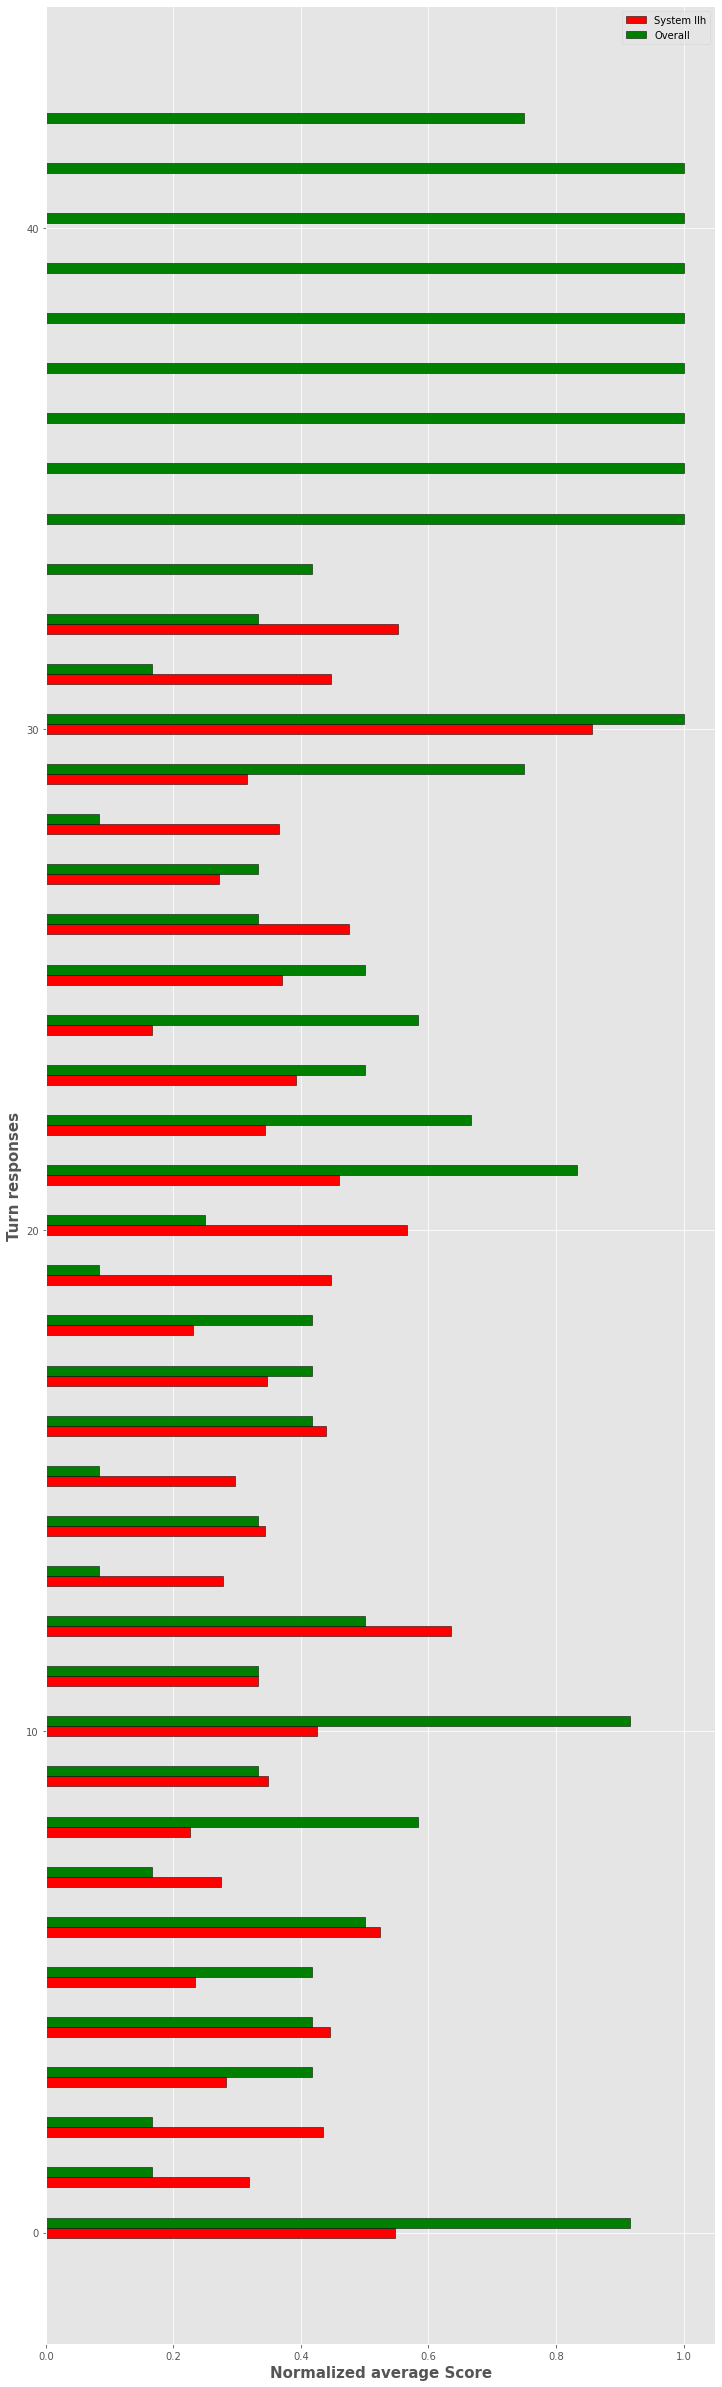

In [12]:
from random import getrandbits, choice
barWidth = 0.2
fig = plt.subplots(figsize =(12, len(normalized_scores_overall)))
colors=["b","r","g","y","c", "m", "b", "w", "grey", "orange"]
used_colors = []

extend__with_bar(0, auto_turn_scores, score_name_x, plt, ["r"], used_colors)

score_name = "Overall"
extend__with_bar(0.2, normalized_scores_overall, score_name, plt, ["g"], used_colors)

plt.style.use('ggplot')
plt.xlabel('Normalized average Score', fontweight ='bold', fontsize = 15)
plt.ylabel('Turn responses', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()


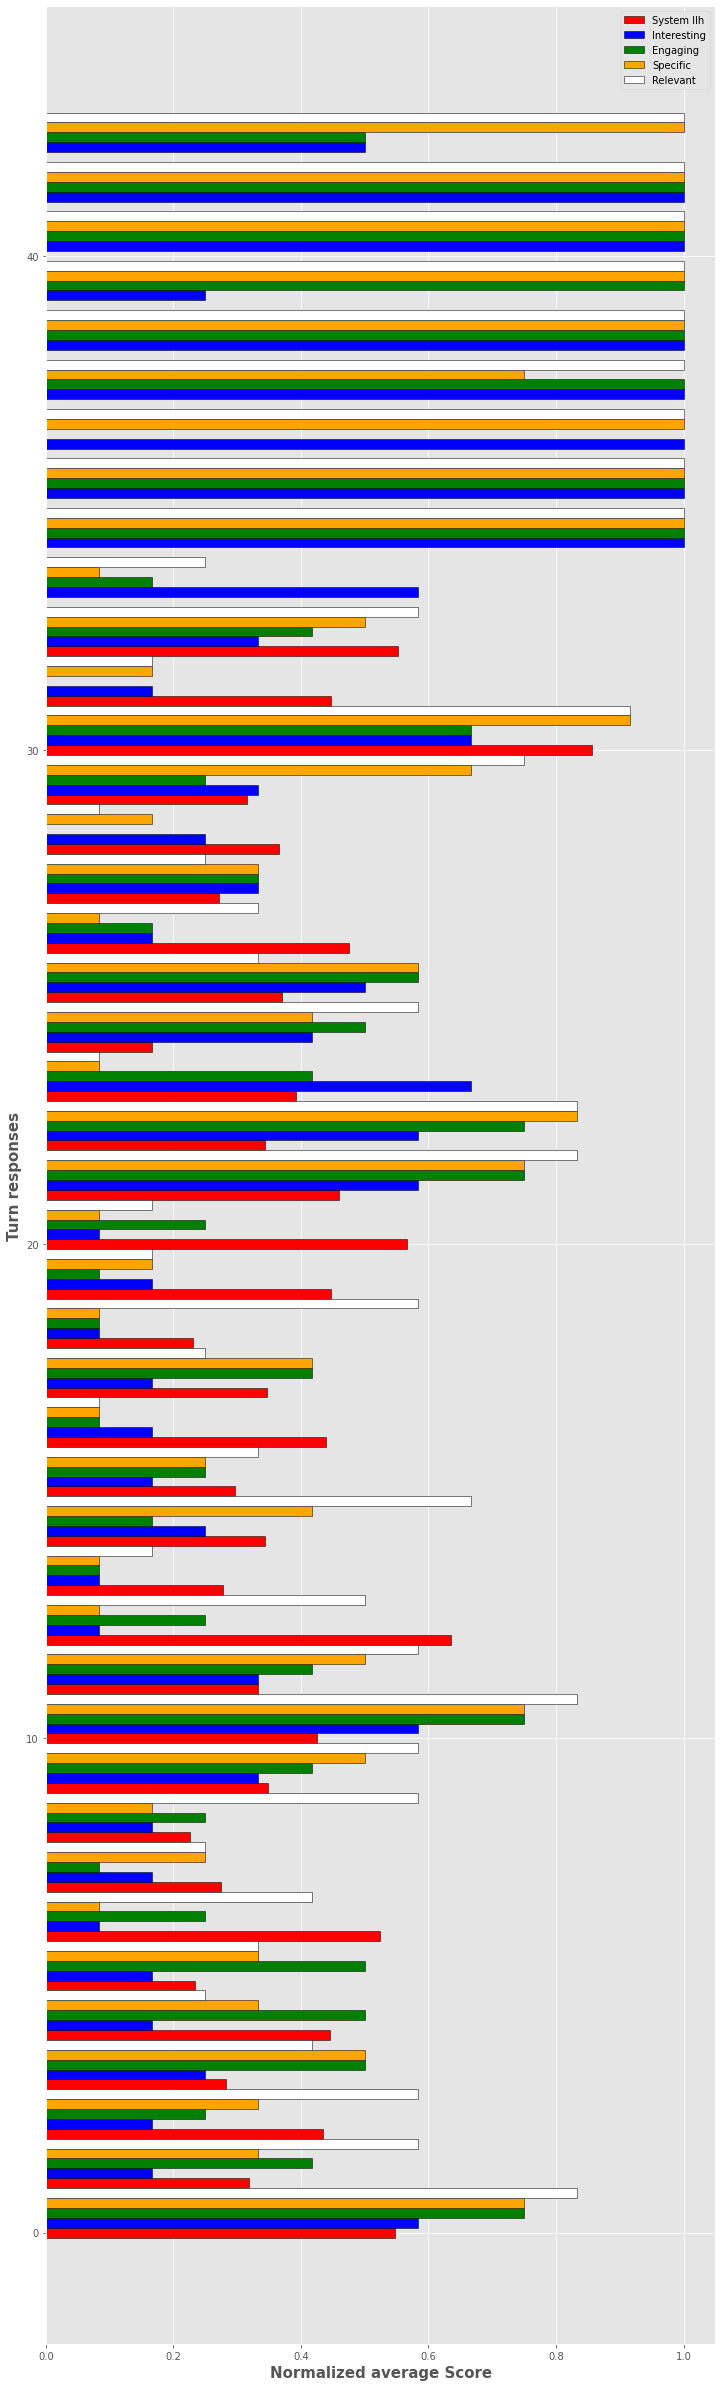

In [14]:
from random import getrandbits, choice
barWidth = 0.2
fig = plt.subplots(figsize =(12, len(normalized_scores_overall)))
colors=["b","r","g","y","c", "m", "b", "w", "grey", "orange"]
used_colors = []

extend__with_bar(0, auto_turn_scores, score_name_x, plt, ["r"], used_colors)


score_name = "Interesting"
extend__with_bar(0.2,normalized_scores_interesting, score_name, plt, ["b"], used_colors)
score_name = "Engaging"
extend__with_bar(0.4,normalized_scores_engaging, score_name, plt, ["g"], used_colors)
score_name = "Specific"
extend__with_bar(0.6,normalized_scores_specific, score_name, plt, ["orange"], used_colors)
score_name = "Relevant"
extend__with_bar(0.8,normalized_scores_relevant, score_name, plt, ["w"], used_colors)


plt.style.use('ggplot')
plt.xlabel('Normalized average Score', fontweight ='bold', fontsize = 15)
plt.ylabel('Turn responses', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()



In [15]:
rows = []

score_name_y = "Overall Human Rating"
mae, mse, rmse = get_mean_error_area(normalized_scores_overall, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Interesting"
mae, mse, rmse = get_mean_error_area(normalized_scores_interesting, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Engaging"
mae, mse, rmse = get_mean_error_area(normalized_scores_engaging, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Specific"
normalized_scores_specific 
mae, mse, rmse = get_mean_error_area(normalized_scores_engaging, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Relevant"
mae, mse, rmse = get_mean_error_area(normalized_scores_relevant,auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Correct"
mae, mse, rmse = get_mean_error_area(normalized_scores_correct, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Semantically Appropriate"
mae, mse, rmse = get_mean_error_area(normalized_scores_semantic, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Understandable" 
mae, mse, rmse = get_mean_error_area(normalized_scores_understandable,auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Fluent"
mae, mse, rmse = get_mean_error_area(normalized_scores_fluent,auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})



df_auto_scores = pd.DataFrame(rows)
df_auto_scores.head()

file = annotation_path+"/"+score_name_x+"_correlation.csv"
df_auto_scores.to_csv(file, index=False)

### MLM likelihood of the language model

In [16]:
score_name_x = "MLM llh"

auto_turn_scores = {}

# We take the turns and scores from the first excel 
# as we assume that the automated data is the same
# for all annotated excel files
for path in basepath.glob('*.csv'):
    df = pd.read_csv(path)
    if 'Turn' in df:
        print(path)
        js = df.to_json(orient = 'records')
        for turn in json.loads(js):
            if turn['Overall Human Rating']:
                get_score_for_turns(turn, auto_turn_scores, score_name_x)

        break ### after the first file we are done

# Check if we have the same numer of keys and make them compatible
for key in normalized_scores_overall:
    if not auto_turn_scores.get(key):
        auto_turn_scores[key]=0
print(len(auto_turn_scores), auto_turn_scores)
print(len(normalized_scores_overall), normalized_scores_overall)


/Users/piek/Desktop/t-MA-Combots-2021/evaluation/leolani2-evaluations/g1-piek/scenario1/2021-12-07-16-26-14_turns83_fina.csv
43 {4: 0.7361755123, 6: 0.6468903413, 8: 0.6876873096, 10: 0.5241628349, 12: 0.6334620598, 14: 0.5192577264, 16: 0.6299969405, 18: 0.5441404155, 20: 0.6244896829, 22: 0.6018532395, 29: 0.5663589814, 31: 0.6286595044, 33: 0.7173709933, 35: 0.5245793313, 37: 0.6157062432, 39: 0.6208760353, 41: 0.5572716693, 43: 0.5092535609, 45: 0.3015928045, 47: 0.4720028381, 49: 0.6483705649, 56: 0.6990316523, 58: 0.7207982664, 60: 0.5253421739, 62: 0.7133867681, 64: 0.4323917404, 66: 0.6391650364, 68: 0.66720617, 70: 0.5721930207, 72: 0.6604242504, 74: 0.6085583214, 76: 0.9281315168, 78: 0.7689278912, 80: 0.714728163, 0: 0, 2: 0, 24: 0, 25: 0, 27: 0, 51: 0, 52: 0, 54: 0, 82: 0}
43 {4: 0.9166666666666667, 6: 0.16666666666666669, 8: 0.16666666666666669, 10: 0.41666666666666663, 12: 0.41666666666666663, 14: 0.41666666666666663, 16: 0.5, 18: 0.16666666666666669, 20: 0.58333333333333

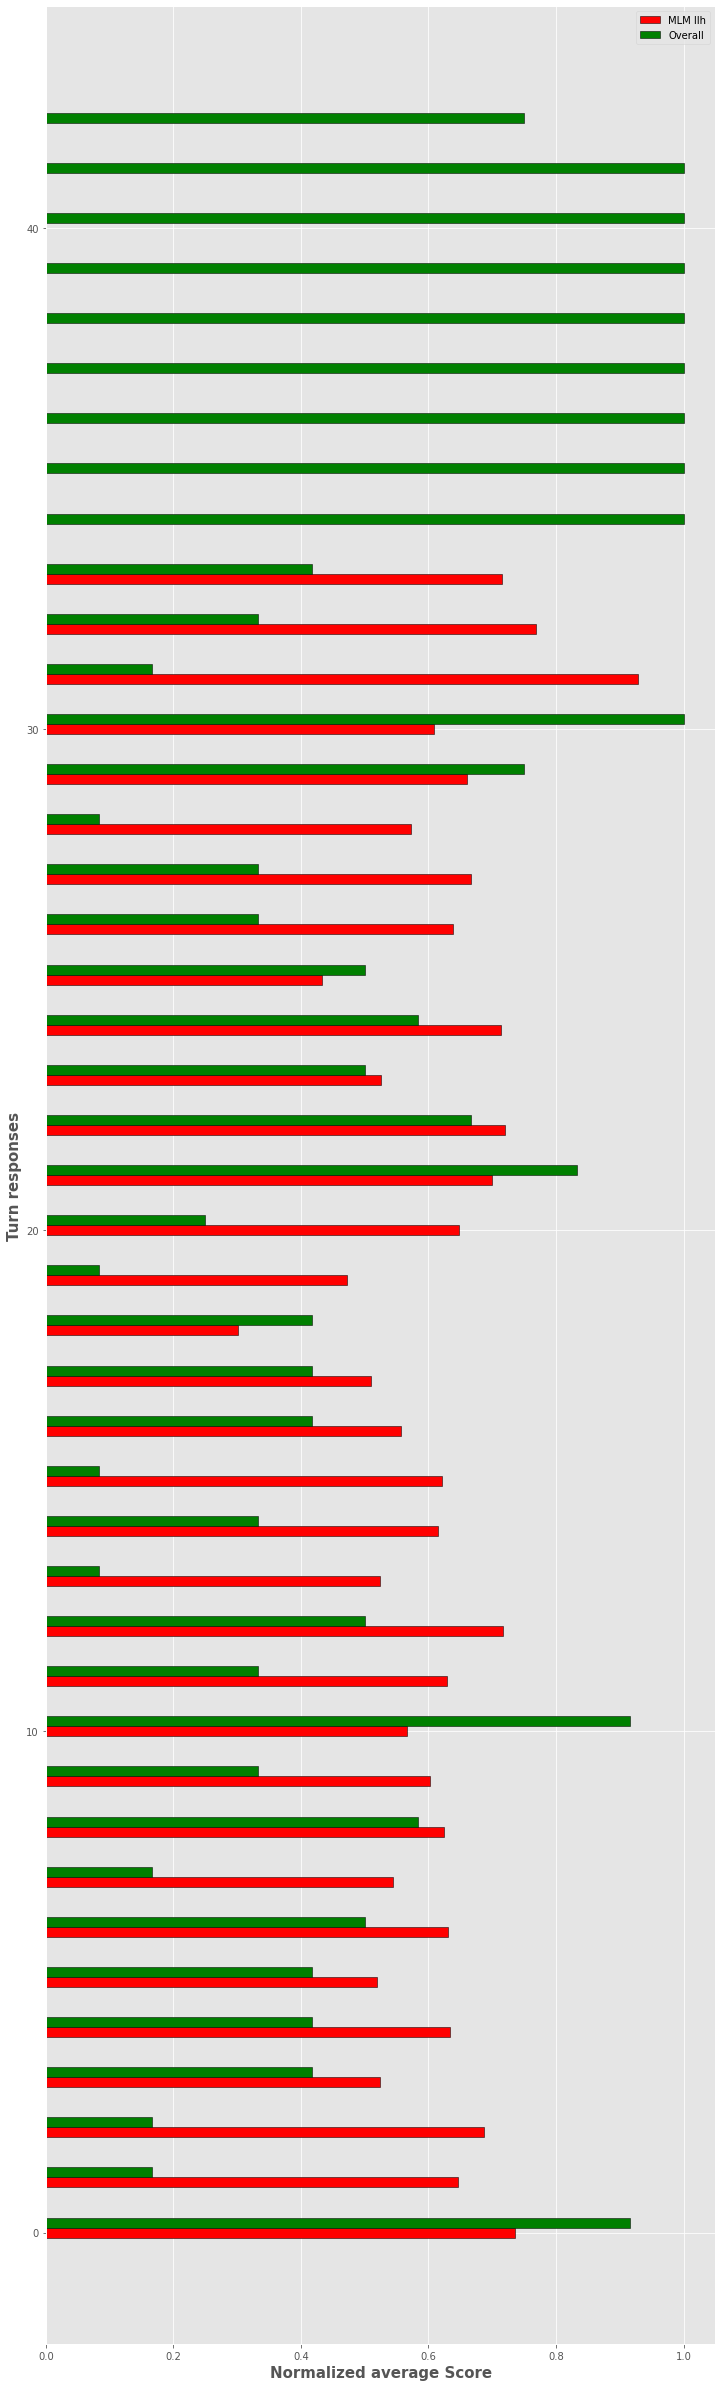

In [17]:
from random import getrandbits, choice
barWidth = 0.2
fig = plt.subplots(figsize =(12, len(normalized_scores_overall)))
colors=["b","r","g","y","c", "m", "b", "w", "grey", "orange"]
used_colors = []

extend__with_bar(0, auto_turn_scores, score_name_x, plt, ["r"], used_colors)

score_name = "Overall"
extend__with_bar(0.2, normalized_scores_overall, score_name, plt, ["g"], used_colors)

plt.style.use('ggplot')
plt.xlabel('Normalized average Score', fontweight ='bold', fontsize = 15)
plt.ylabel('Turn responses', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

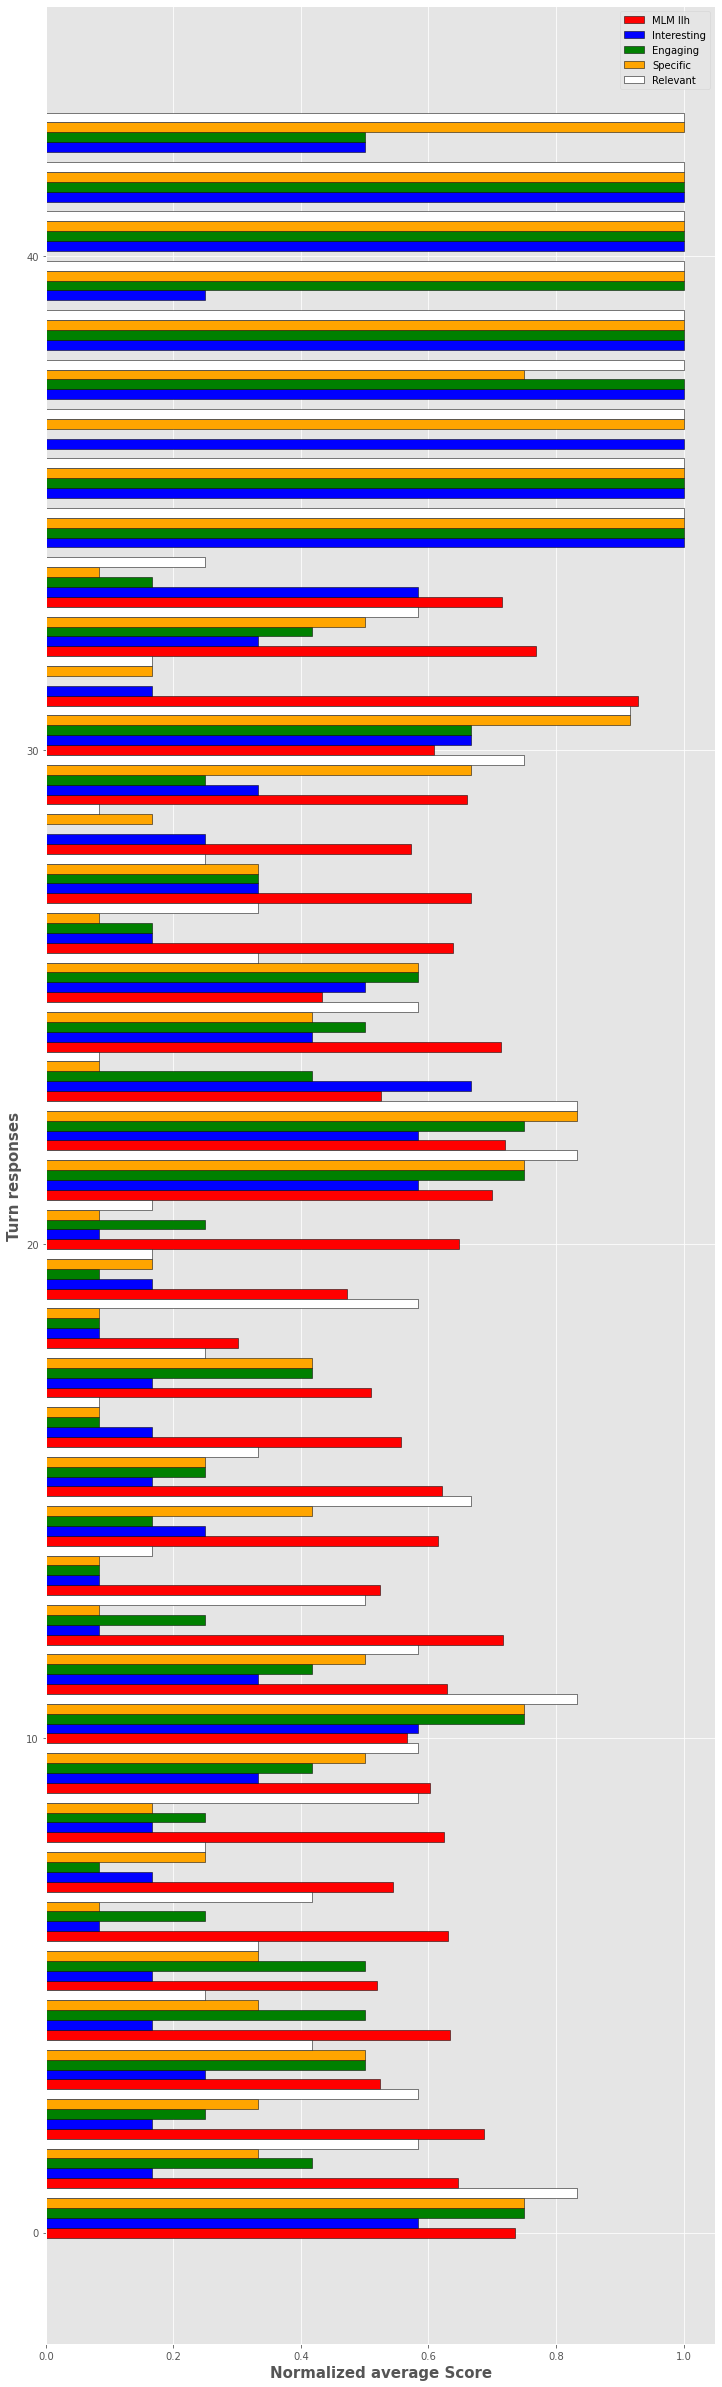

In [18]:
from random import getrandbits, choice
barWidth = 0.2
fig = plt.subplots(figsize =(12, len(normalized_scores_overall)))
colors=["b","r","g","y","c", "m", "b", "w", "grey", "orange"]
used_colors = []

extend__with_bar(0, auto_turn_scores, score_name_x, plt, ["r"], used_colors)

score_name = "Interesting"
extend__with_bar(0.2,normalized_scores_interesting, score_name, plt, ["b"], used_colors)
score_name = "Engaging"
extend__with_bar(0.4,normalized_scores_engaging, score_name, plt, ["g"], used_colors)
score_name = "Specific"
extend__with_bar(0.6,normalized_scores_specific, score_name, plt, ["orange"], used_colors)
score_name = "Relevant"
extend__with_bar(0.8,normalized_scores_relevant, score_name, plt, ["w"], used_colors)

plt.style.use('ggplot')
plt.xlabel('Normalized average Score', fontweight ='bold', fontsize = 15)
plt.ylabel('Turn responses', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

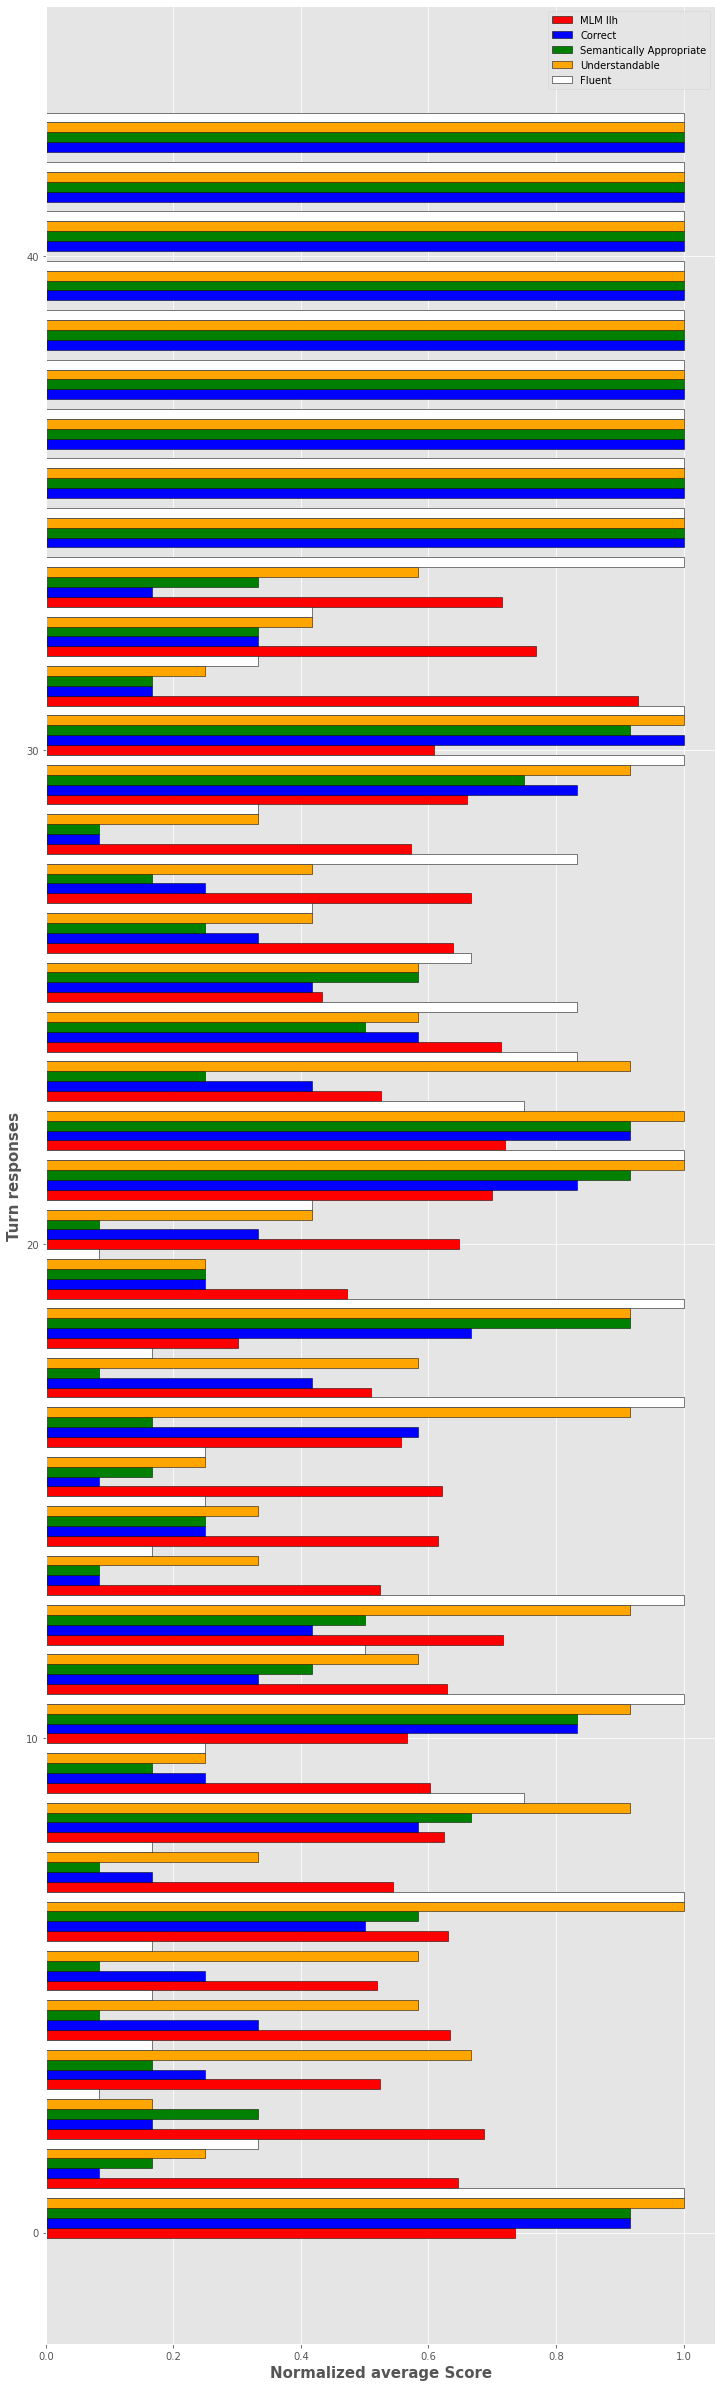

In [19]:
from random import getrandbits, choice
barWidth = 0.2
fig = plt.subplots(figsize =(12, len(normalized_scores_overall)))
colors=["b","r","g","y","c", "m", "b", "w", "grey", "orange"]
used_colors = []

extend__with_bar(0, auto_turn_scores, score_name_x, plt, ["r"], used_colors)

score_name = "Correct"
extend__with_bar(0.2,normalized_scores_correct, score_name, plt, ["b"], used_colors)
score_name = "Semantically Appropriate"
extend__with_bar(0.4,normalized_scores_semantic, score_name, plt, ["g"], used_colors)
score_name = "Understandable"
extend__with_bar(0.6,normalized_scores_understandable, score_name, plt, ["orange"], used_colors)
score_name = "Fluent"
extend__with_bar(0.8,normalized_scores_fluent, score_name, plt, ["w"], used_colors)

plt.style.use('ggplot')
plt.xlabel('Normalized average Score', fontweight ='bold', fontsize = 15)
plt.ylabel('Turn responses', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

In [20]:
rows = []

score_name_y = "Overall Human Rating"
mae, mse, rmse = get_mean_error_area(normalized_scores_overall, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Interesting"
mae, mse, rmse = get_mean_error_area(normalized_scores_interesting, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Engaging"
mae, mse, rmse = get_mean_error_area(normalized_scores_engaging, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Specific"
normalized_scores_specific 
mae, mse, rmse = get_mean_error_area(normalized_scores_engaging, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Relevant"
mae, mse, rmse = get_mean_error_area(normalized_scores_relevant,auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Correct"
mae, mse, rmse = get_mean_error_area(normalized_scores_correct, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Semantically Appropriate"
mae, mse, rmse = get_mean_error_area(normalized_scores_semantic, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Understandable" 
mae, mse, rmse = get_mean_error_area(normalized_scores_understandable,auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Fluent"
mae, mse, rmse = get_mean_error_area(normalized_scores_fluent,auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

df_auto_scores = pd.DataFrame(rows)
df_auto_scores.head()

file = annotation_path+"/"+score_name_x+"_correlation.csv"
df_auto_scores.to_csv(file, index=False)

### USR DLcontext

In [21]:
score_name_x = "USR DLcontext"

auto_turn_scores = {}

# We take the turns and scores from the first excel 
# as we assume that the automated data is the same
# for all annotated excel files
for path in basepath.glob('*.csv'):
    df = pd.read_csv(path)
    if 'Turn' in df:
        print(path)
        js = df.to_json(orient = 'records')
        for turn in json.loads(js):
            if turn['Overall Human Rating']:
                get_score_for_turns(turn, auto_turn_scores, score_name_x)

        break ### after the first file we are done

### Check if we have the same numer of keys and make them compatible
for key in normalized_scores_overall:
    if not auto_turn_scores.get(key):
        auto_turn_scores[key]=0
print(len(auto_turn_scores), auto_turn_scores)
print(len(normalized_scores_overall), normalized_scores_overall)

/Users/piek/Desktop/t-MA-Combots-2021/evaluation/leolani2-evaluations/g1-piek/scenario1/2021-12-07-16-26-14_turns83_fina.csv
43 {4: 0.9693412, 6: 0.90223813, 8: 0.99794054, 10: 0.9981058, 12: 0.99818295, 14: 0.9963226, 16: 0.994314, 18: 0.9944816, 20: 0.9966193, 22: 0.99736065, 29: 0.9939426, 31: 0.0859445, 33: 0.074241705, 35: 0.5525402, 37: 0.5685659, 39: 0.9948092, 41: 0.99701506, 43: 0.9973986, 45: 0.997453, 47: 0.9926834, 49: 0.3522885, 56: 0.051071912, 58: 0.9836426, 60: 0.9370247, 62: 0.9900606, 64: 0.9944463, 66: 0.9971736, 68: 0.9979252, 70: 0.9941706, 72: 0.9981081, 74: 0.9977023, 76: 0.99802655, 78: 0.99719965, 80: 0.9970385, 0: 0, 2: 0, 24: 0, 25: 0, 27: 0, 51: 0, 52: 0, 54: 0, 82: 0}
43 {4: 0.9166666666666667, 6: 0.16666666666666669, 8: 0.16666666666666669, 10: 0.41666666666666663, 12: 0.41666666666666663, 14: 0.41666666666666663, 16: 0.5, 18: 0.16666666666666669, 20: 0.5833333333333334, 22: 0.33333333333333337, 29: 0.9166666666666667, 31: 0.33333333333333337, 33: 0.5, 35:

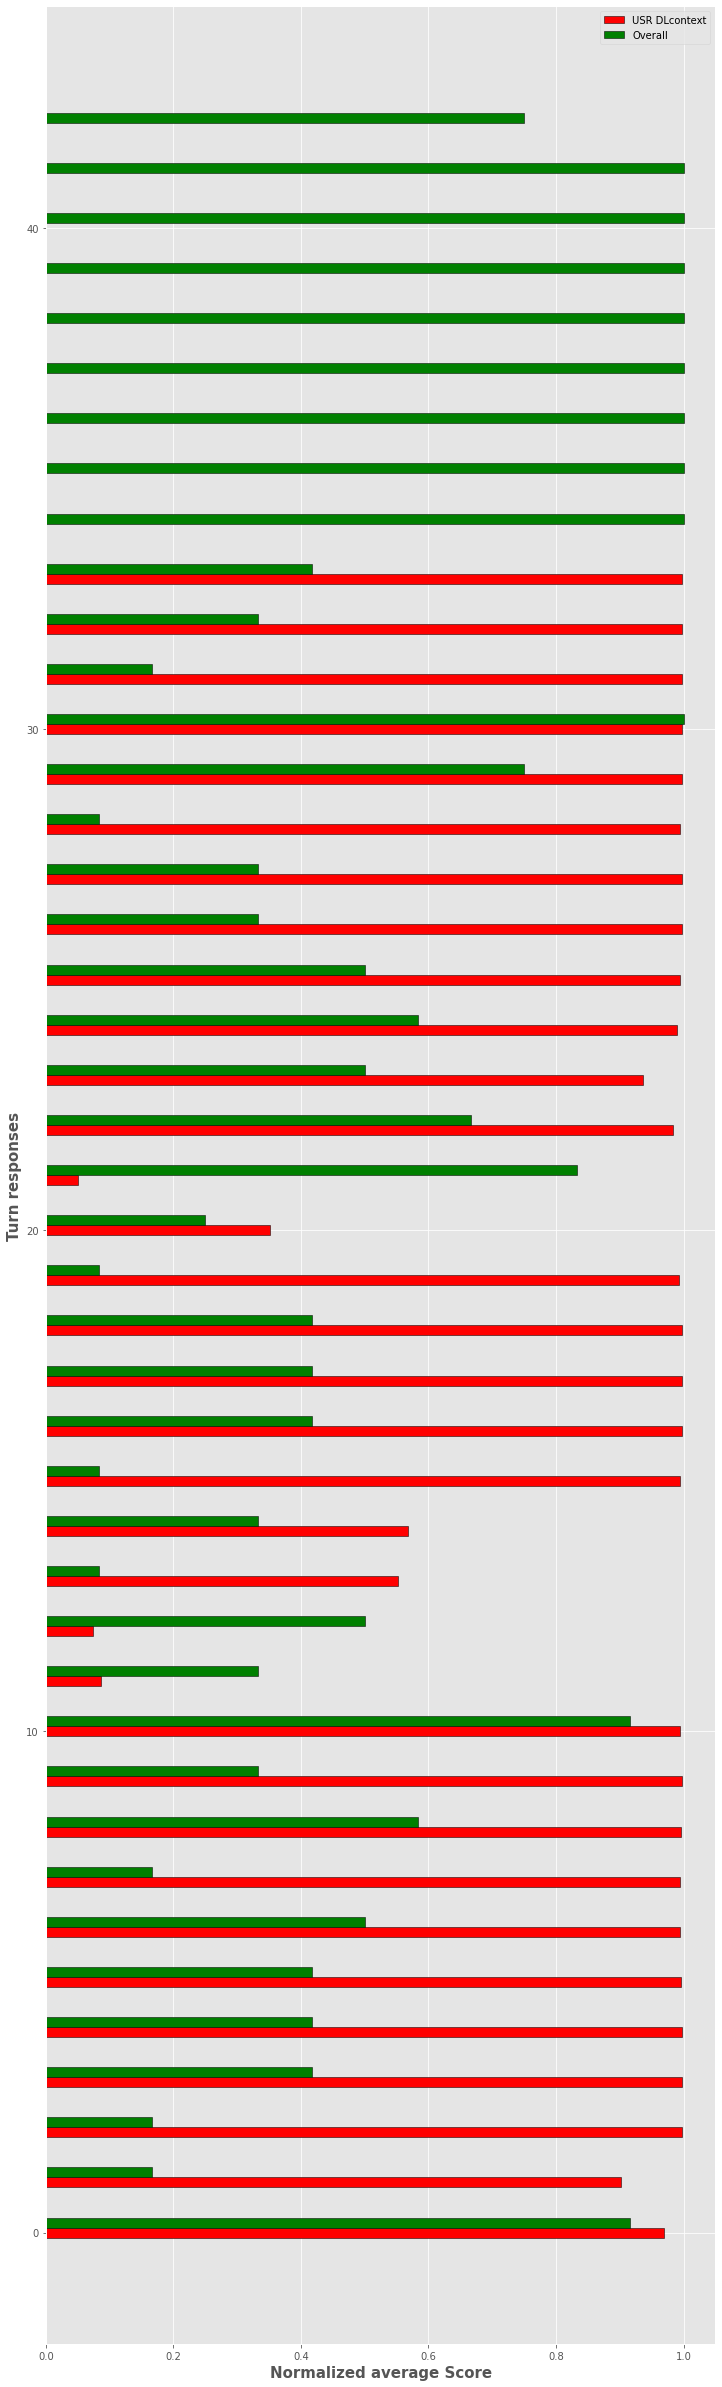

In [22]:
from random import getrandbits, choice
barWidth = 0.2
fig = plt.subplots(figsize =(12, len(normalized_scores_overall)))
colors=["b","r","g","y","c", "m", "b", "w", "grey", "orange"]
used_colors = []

extend__with_bar(0, auto_turn_scores, score_name_x, plt, ["r"], used_colors)

score_name = "Overall"
extend__with_bar(0.2, normalized_scores_overall, score_name, plt, ["g"], used_colors)

plt.style.use('ggplot')
plt.xlabel('Normalized average Score', fontweight ='bold', fontsize = 15)
plt.ylabel('Turn responses', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

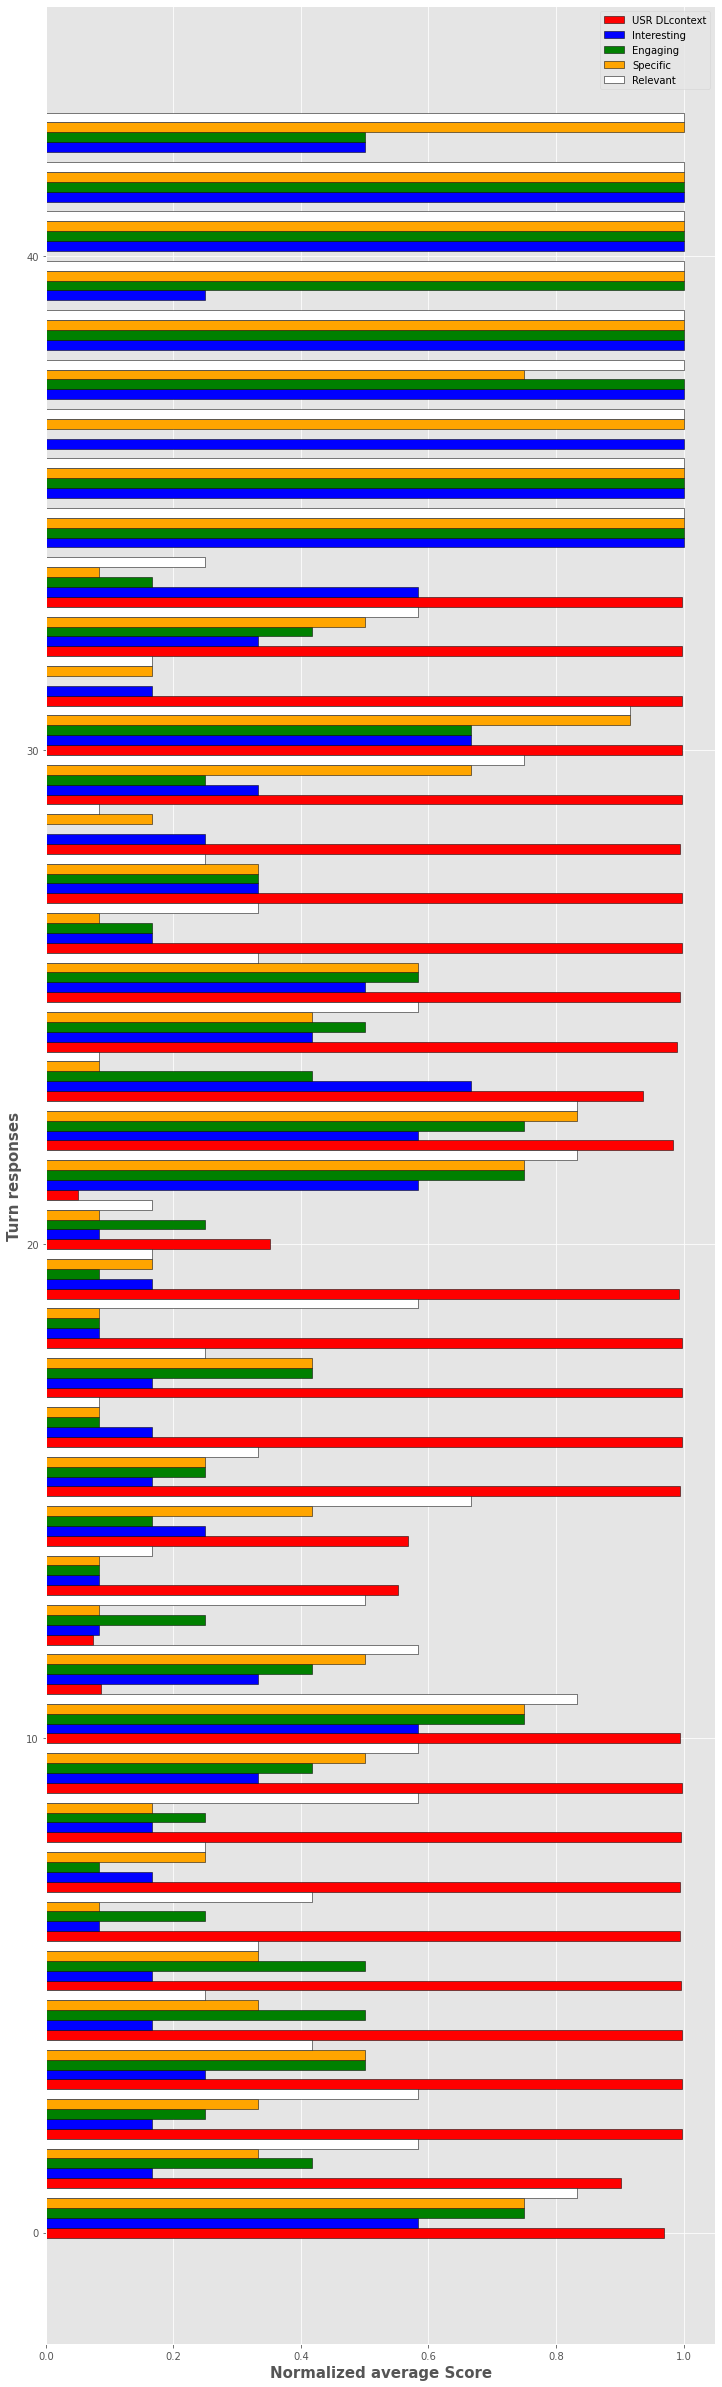

In [23]:
from random import getrandbits, choice
barWidth = 0.2
fig = plt.subplots(figsize =(12, len(normalized_scores_overall)))
colors=["b","r","g","y","c", "m", "b", "w", "grey", "orange"]
used_colors = []

extend__with_bar(0, auto_turn_scores, score_name_x, plt, ["r"], used_colors)

score_name = "Interesting"
extend__with_bar(0.2,normalized_scores_interesting, score_name, plt, ["b"], used_colors)
score_name = "Engaging"
extend__with_bar(0.4,normalized_scores_engaging, score_name, plt, ["g"], used_colors)
score_name = "Specific"
extend__with_bar(0.6,normalized_scores_specific, score_name, plt, ["orange"], used_colors)
score_name = "Relevant"
extend__with_bar(0.8,normalized_scores_relevant, score_name, plt, ["w"], used_colors)

plt.style.use('ggplot')
plt.xlabel('Normalized average Score', fontweight ='bold', fontsize = 15)
plt.ylabel('Turn responses', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

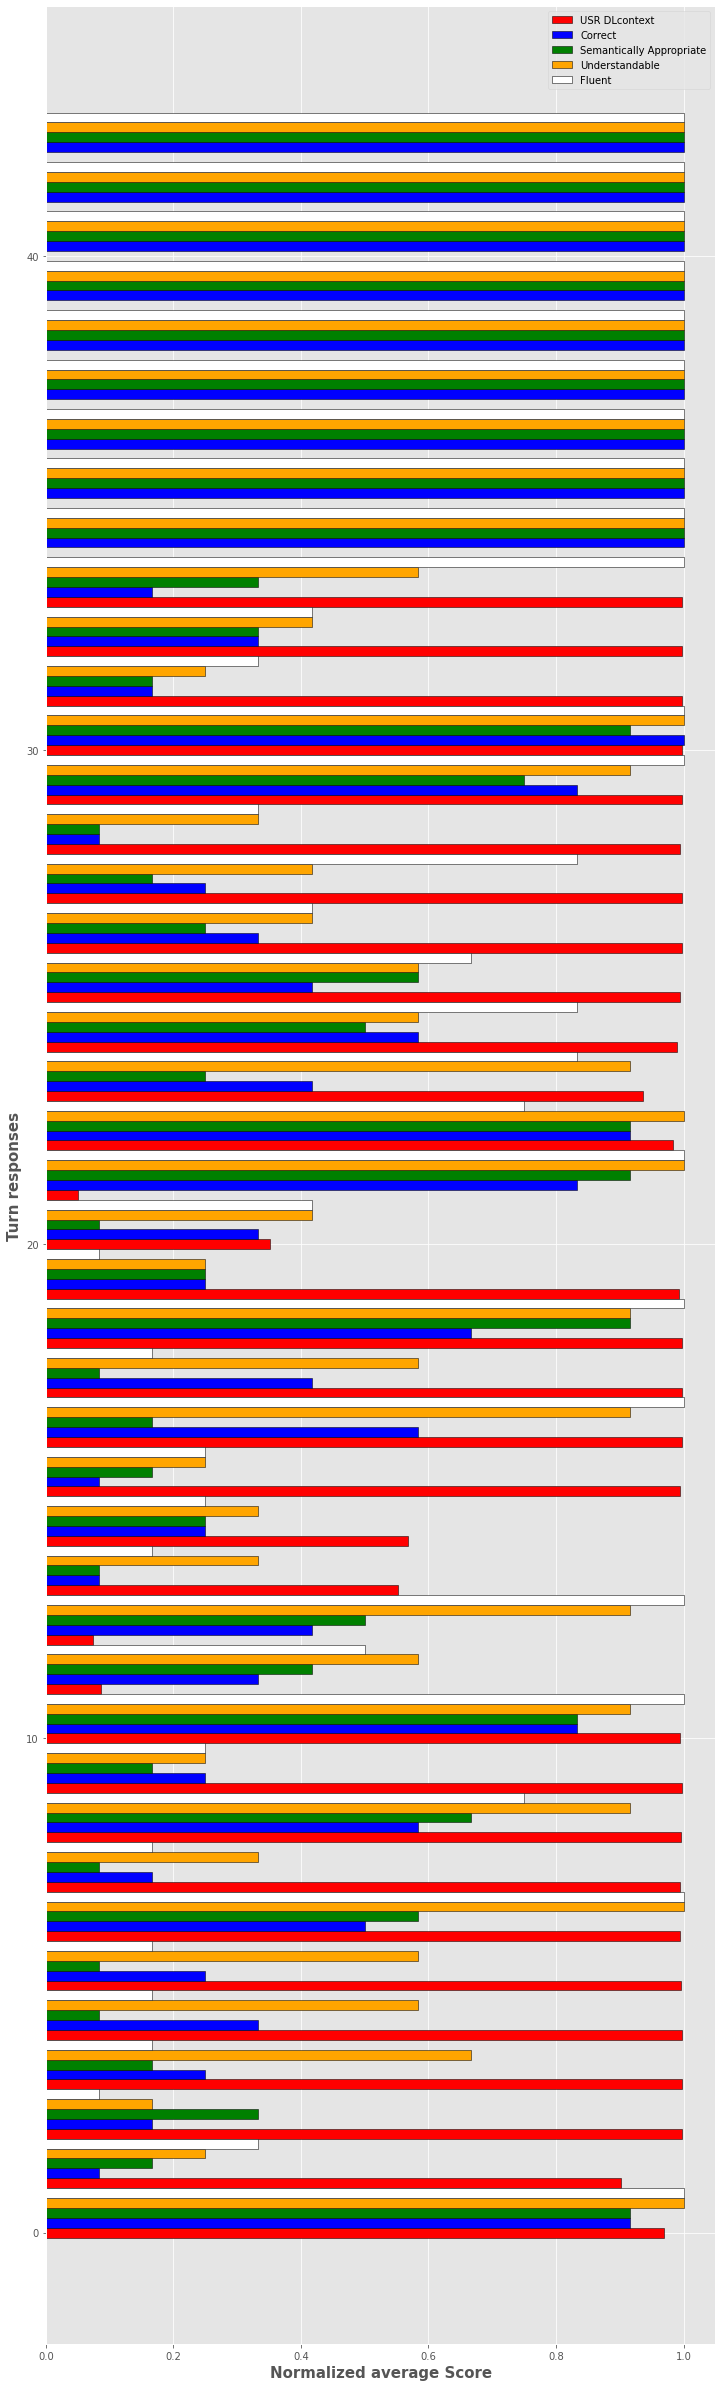

In [24]:
from random import getrandbits, choice
barWidth = 0.2
fig = plt.subplots(figsize =(12, len(normalized_scores_overall)))
colors=["b","r","g","y","c", "m", "b", "w", "grey", "orange"]
used_colors = []

extend__with_bar(0, auto_turn_scores, score_name_x, plt, ["r"], used_colors)

score_name = "Correct"
extend__with_bar(0.2,normalized_scores_correct, score_name, plt, ["b"], used_colors)
score_name = "Semantically Appropriate"
extend__with_bar(0.4,normalized_scores_semantic, score_name, plt, ["g"], used_colors)
score_name = "Understandable"
extend__with_bar(0.6,normalized_scores_understandable, score_name, plt, ["orange"], used_colors)
score_name = "Fluent"
extend__with_bar(0.8,normalized_scores_fluent, score_name, plt, ["w"], used_colors)

plt.style.use('ggplot')
plt.xlabel('Normalized average Score', fontweight ='bold', fontsize = 15)
plt.ylabel('Turn responses', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

In [25]:
rows = []

score_name_y = "Overall Human Rating"
mae, mse, rmse = get_mean_error_area(normalized_scores_overall, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Interesting"
mae, mse, rmse = get_mean_error_area(normalized_scores_interesting, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Engaging"
mae, mse, rmse = get_mean_error_area(normalized_scores_engaging, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Specific"
normalized_scores_specific 
mae, mse, rmse = get_mean_error_area(normalized_scores_engaging, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Relevant"
mae, mse, rmse = get_mean_error_area(normalized_scores_relevant,auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Correct"
mae, mse, rmse = get_mean_error_area(normalized_scores_correct, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Semantically Appropriate"
mae, mse, rmse = get_mean_error_area(normalized_scores_semantic, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Understandable" 
mae, mse, rmse = get_mean_error_area(normalized_scores_understandable,auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Fluent"
mae, mse, rmse = get_mean_error_area(normalized_scores_fluent,auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

df_auto_scores = pd.DataFrame(rows)
df_auto_scores.head()

file = annotation_path+"/"+score_name_x+"_correlation.csv"
df_auto_scores.to_csv(file, index=False)

### USR DLfact

In [26]:
score_name_x = "USR DLfact"

auto_turn_scores = {}

# We take the turns and scores from the first excel 
# as we assume that the automated data is the same
# for all annotated excel files
for path in basepath.glob('*.csv'):
    df = pd.read_csv(path)
    if 'Turn' in df:
        print(path)
        js = df.to_json(orient = 'records')
        for turn in json.loads(js):
            if turn['Overall Human Rating']:
                get_score_for_turns(turn, auto_turn_scores, score_name_x)

        break ### after the first file we are done

### Check if we have the same numer of keys and make them compatible
for key in normalized_scores_overall:
    if not auto_turn_scores.get(key):
        auto_turn_scores[key]=0
print(len(auto_turn_scores), auto_turn_scores)
print(len(normalized_scores_overall), normalized_scores_overall)



/Users/piek/Desktop/t-MA-Combots-2021/evaluation/leolani2-evaluations/g1-piek/scenario1/2021-12-07-16-26-14_turns83_fina.csv
43 {4: 0.7391765, 6: 0.9182499, 8: 0.6647635, 10: 0.9950086, 12: 0.99711967, 14: 0.9971608, 16: 0.99669886, 18: 0.9952389, 20: 0.9970807, 22: 0.99652666, 29: 0.9943281, 31: 0.9527872, 33: 0.26481175, 35: 0.99571604, 37: 0.99217486, 39: 0.9452235, 41: 0.9960477, 43: 0.99680585, 45: 0.99690706, 47: 0.9965291, 49: 0.7085089, 56: 0.70138174, 58: 0.9923688, 60: 0.9943393, 62: 0.68595, 64: 0.27711132, 66: 0.9928405, 68: 0.9965834, 70: 0.9970216, 72: 0.9971887, 74: 0.99702716, 76: 0.9972578, 78: 0.9971448, 80: 0.72265506, 0: 0, 2: 0, 24: 0, 25: 0, 27: 0, 51: 0, 52: 0, 54: 0, 82: 0}
43 {4: 0.9166666666666667, 6: 0.16666666666666669, 8: 0.16666666666666669, 10: 0.41666666666666663, 12: 0.41666666666666663, 14: 0.41666666666666663, 16: 0.5, 18: 0.16666666666666669, 20: 0.5833333333333334, 22: 0.33333333333333337, 29: 0.9166666666666667, 31: 0.33333333333333337, 33: 0.5, 35

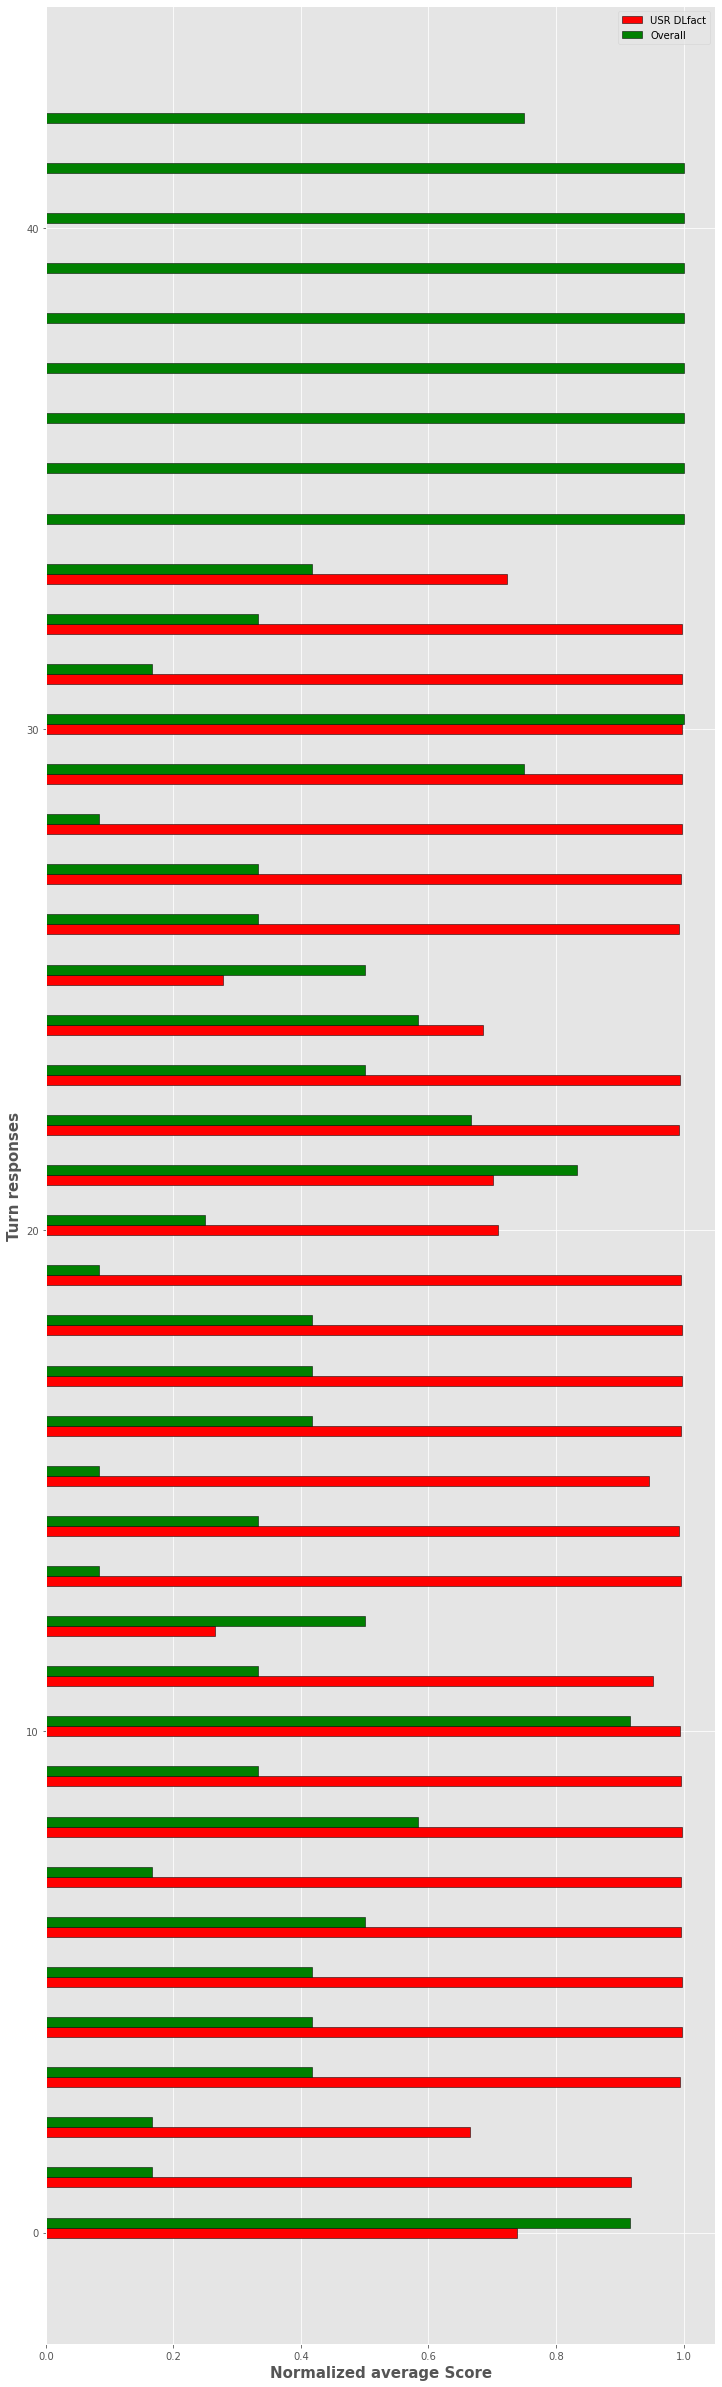

In [27]:
from random import getrandbits, choice
barWidth = 0.2
fig = plt.subplots(figsize =(12, len(normalized_scores_overall)))
colors=["b","r","g","y","c", "m", "b", "w", "grey", "orange"]
used_colors = []

extend__with_bar(0, auto_turn_scores, score_name_x, plt, ["r"], used_colors)

score_name = "Overall"
extend__with_bar(0.2, normalized_scores_overall, score_name, plt, ["g"], used_colors)

plt.style.use('ggplot')
plt.xlabel('Normalized average Score', fontweight ='bold', fontsize = 15)
plt.ylabel('Turn responses', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

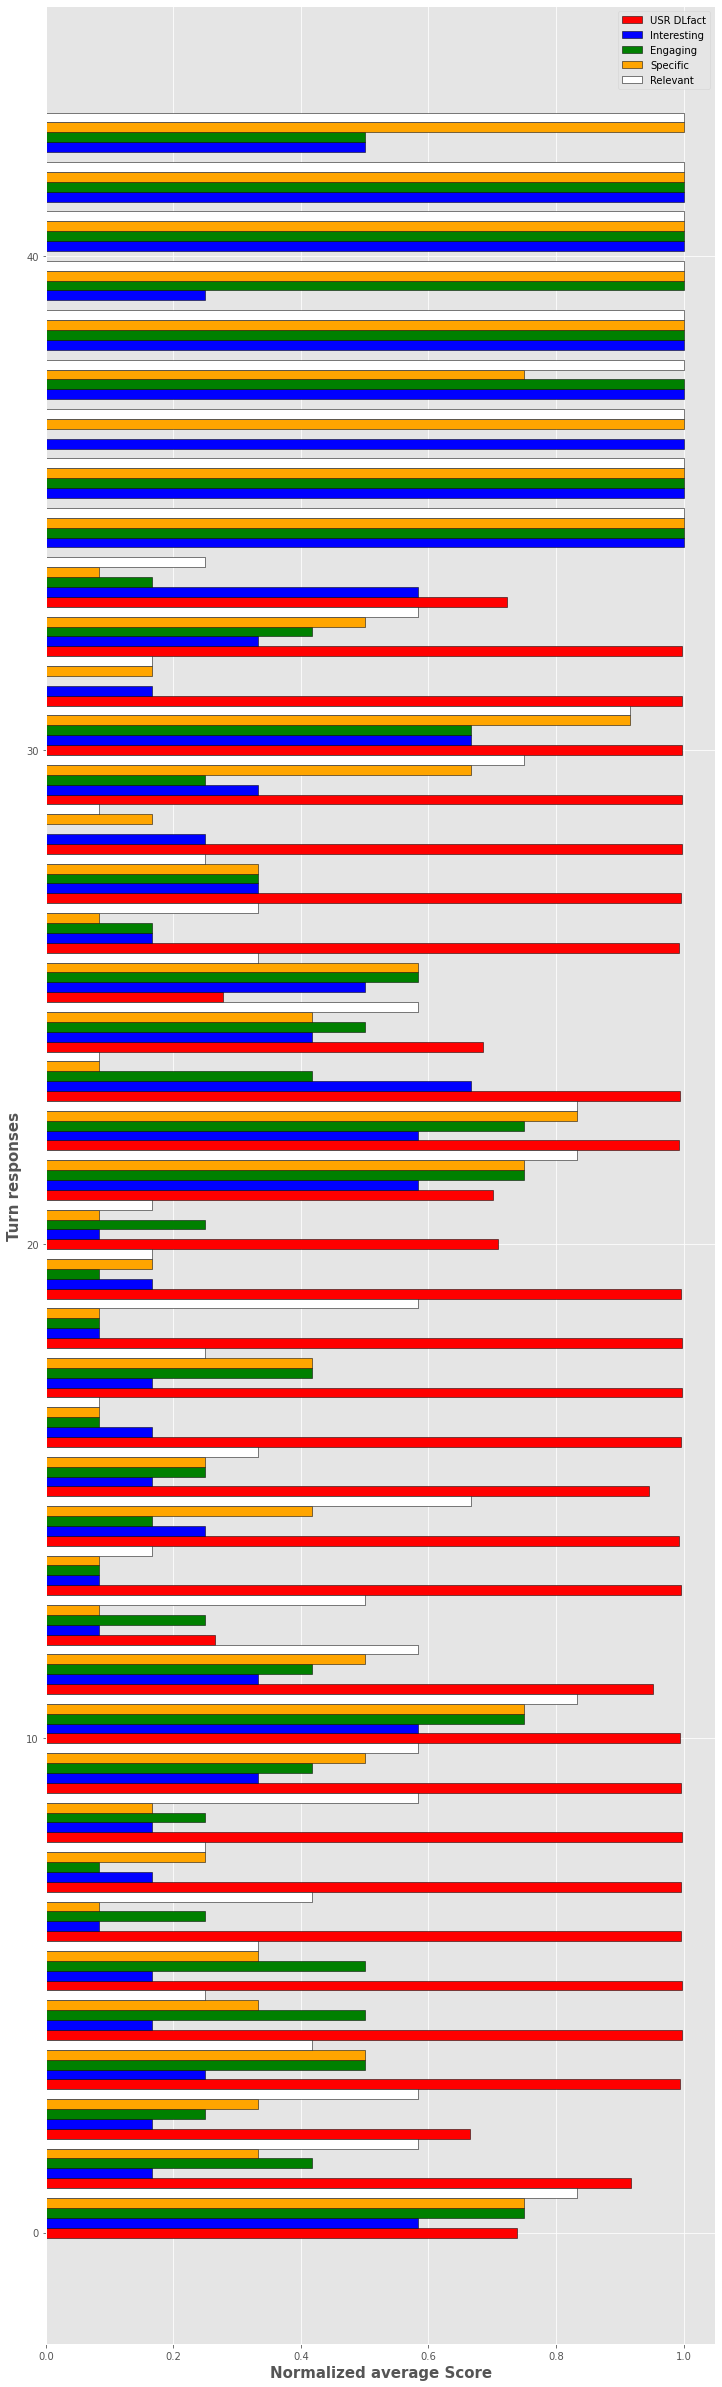

In [28]:
from random import getrandbits, choice
barWidth = 0.2
fig = plt.subplots(figsize =(12, len(normalized_scores_overall)))
colors=["b","r","g","y","c", "m", "b", "w", "grey", "orange"]
used_colors = []

extend__with_bar(0, auto_turn_scores, score_name_x, plt, ["r"], used_colors)

score_name = "Interesting"
extend__with_bar(0.2,normalized_scores_interesting, score_name, plt, ["b"], used_colors)
score_name = "Engaging"
extend__with_bar(0.4,normalized_scores_engaging, score_name, plt, ["g"], used_colors)
score_name = "Specific"
extend__with_bar(0.6,normalized_scores_specific, score_name, plt, ["orange"], used_colors)
score_name = "Relevant"
extend__with_bar(0.8,normalized_scores_relevant, score_name, plt, ["w"], used_colors)

plt.style.use('ggplot')
plt.xlabel('Normalized average Score', fontweight ='bold', fontsize = 15)
plt.ylabel('Turn responses', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

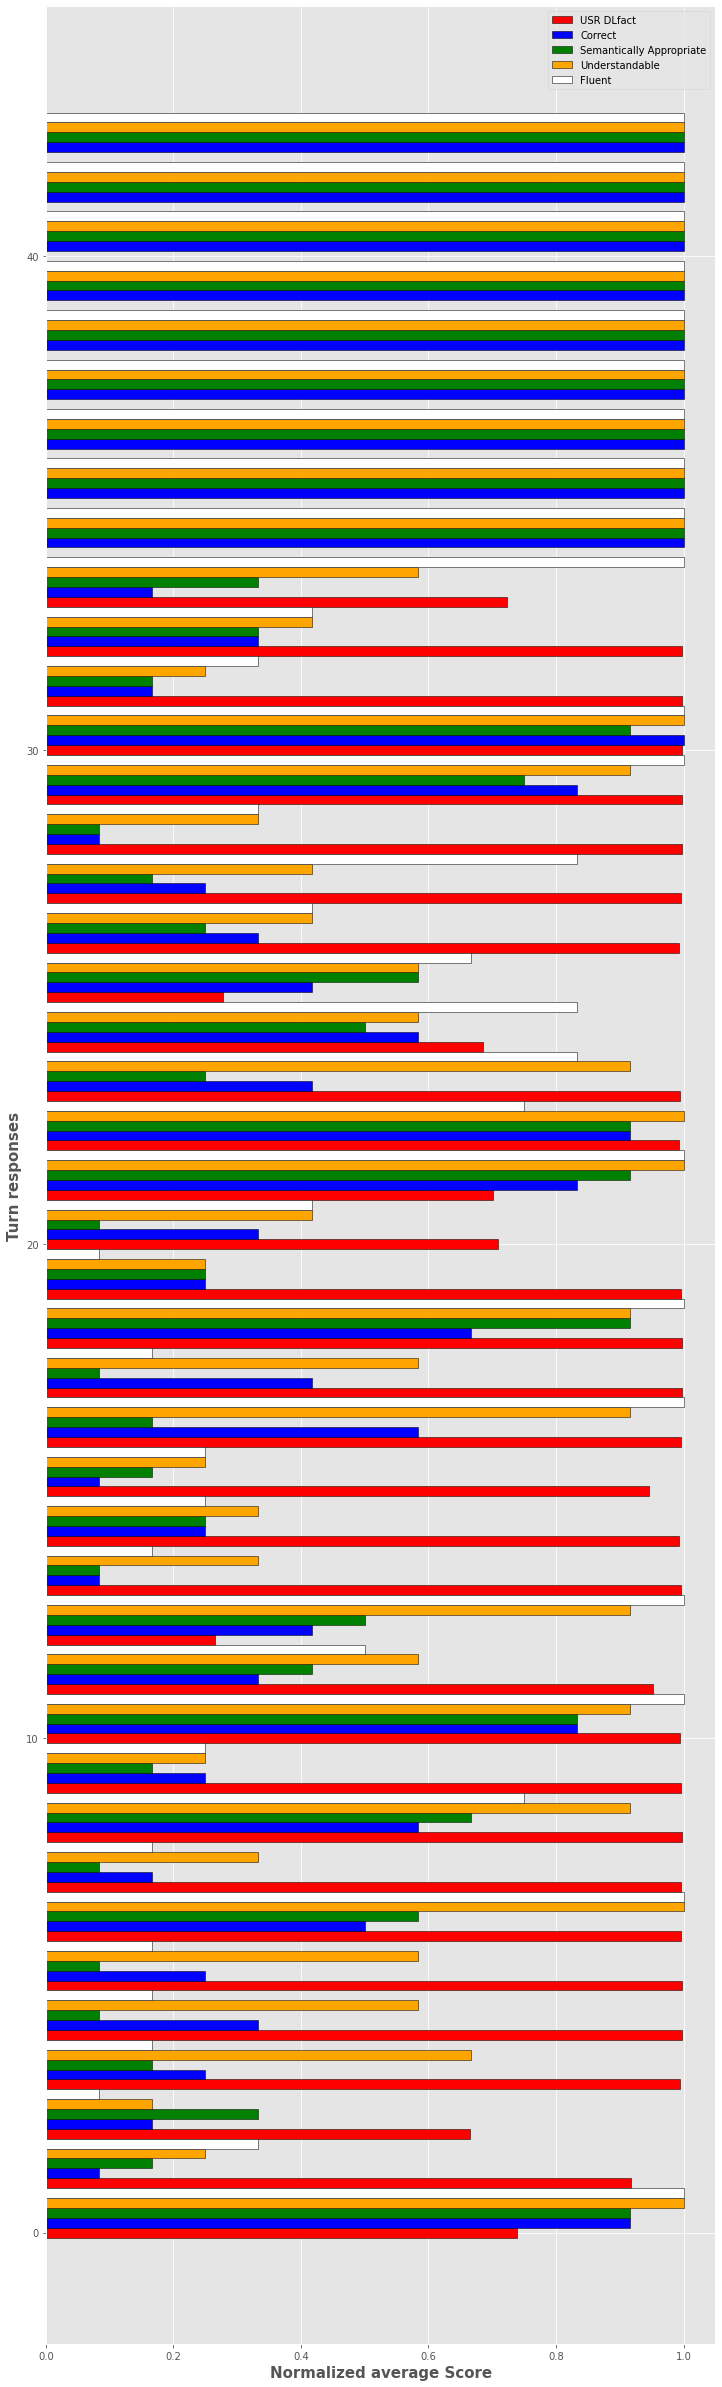

In [29]:
from random import getrandbits, choice
barWidth = 0.2
fig = plt.subplots(figsize =(12, len(normalized_scores_overall)))
colors=["b","r","g","y","c", "m", "b", "w", "grey", "orange"]
used_colors = []

extend__with_bar(0, auto_turn_scores, score_name_x, plt, ["r"], used_colors)

score_name = "Correct"
extend__with_bar(0.2,normalized_scores_correct, score_name, plt, ["b"], used_colors)
score_name = "Semantically Appropriate"
extend__with_bar(0.4,normalized_scores_semantic, score_name, plt, ["g"], used_colors)
score_name = "Understandable"
extend__with_bar(0.6,normalized_scores_understandable, score_name, plt, ["orange"], used_colors)
score_name = "Fluent"
extend__with_bar(0.8,normalized_scores_fluent, score_name, plt, ["w"], used_colors)

plt.style.use('ggplot')
plt.xlabel('Normalized average Score', fontweight ='bold', fontsize = 15)
plt.ylabel('Turn responses', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

In [30]:
rows = []

score_name_y = "Overall Human Rating"
mae, mse, rmse = get_mean_error_area(normalized_scores_overall, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Interesting"
mae, mse, rmse = get_mean_error_area(normalized_scores_interesting, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Engaging"
mae, mse, rmse = get_mean_error_area(normalized_scores_engaging, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Specific"
normalized_scores_specific 
mae, mse, rmse = get_mean_error_area(normalized_scores_engaging, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Relevant"
mae, mse, rmse = get_mean_error_area(normalized_scores_relevant,auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Correct"
mae, mse, rmse = get_mean_error_area(normalized_scores_correct, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Semantically Appropriate"
mae, mse, rmse = get_mean_error_area(normalized_scores_semantic, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Understandable" 
mae, mse, rmse = get_mean_error_area(normalized_scores_understandable,auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Fluent"
mae, mse, rmse = get_mean_error_area(normalized_scores_fluent,auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

df_auto_scores = pd.DataFrame(rows)
df_auto_scores.head()

file = annotation_path+"/"+score_name_x+"_correlation.csv"
df_auto_scores.to_csv(file, index=False)

## End of notebook